**Table of contents**   
- [Aims](#aims)    
  - [Method](#method)    
    - [Plotting](#plotting)    
  - [Conclusion](#conclusion)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [22]:
database_service = "sqlite"
database = "jupiter.db"
connectable =  f"{database_service}:///{database}" ## Creating a variable to connect to the database

db_contents = pd.read_sql("SELECT * FROM sqlite_master", connectable) ## Creating a variable to contain the details of the database

moons = pd.read_sql("SELECT * FROM moons", connectable) ## Creating a variable to contain the details of the moons table

In [23]:
def scat_plot(data, x, y, alpha = 0.7, hue = "group", **kwargs):
    sns.scatterplot(data = data, x = x, y = y, alpha = alpha, hue = hue, **kwargs)

## <a id='toc1_1_'></a>[Aims](#toc0_)

For this task, I already have a regression plot of $T^2$ against $a^3$, however, the units used for each axis do not match the units of the gravitational constant (G) which are $m^3 kg^{-1} s^{-2}$.  
To correct this, I will replot the graph, using a conversion of  

$$\text{distance\_m = distance\_km * 1000}$$
$$\text{period\_s = period\_days * 86400}$$

and then find the new gradient of the line of best fit which can be used to find the mass of Jupiter.  

I do not believe that hyperparameters are at all necessary to perform this linear model.  
This is due to the relationship between period and distance being already well-defined by Kepler's Third Law, therefore the function to find the gradient is not having to find a new pattern but simply has to extract a value from the known model.

If hyperparameters were introduced, it would add unnecessary complexity to the program without actually improving the model's accuracy.

## <a id='toc1_2_'></a>[Method](#toc0_)

I have this equation:
$$T^{2} = \frac{4\pi^{2}}{GM}a^{3}$$
from Kepler's Third Law.  
Comparing this to a straight line graph;
$$y = mx + c$$
it is clear that this equation represents a straight line which passes through the origin and has a gradient of $\frac{4\pi^2}{GM}$ when $T^2$ is plot against $a^3$.  
The mass of the object being orbit, in this case Jupiter, is defined by the $M$ value in the denominator of the gradient, and this is the value I wish to calculate for this task.

### <a id='toc1_2_1_'></a>[Plotting](#toc0_)

First I will create new columns in a data frame to hold the converted values of T and a.  
Then I will plot a new graph of $T^2$ against $a^3$ and use np.polyfit() to calculate the new gradient with the correct units of $\frac{s^2}{m^3}$

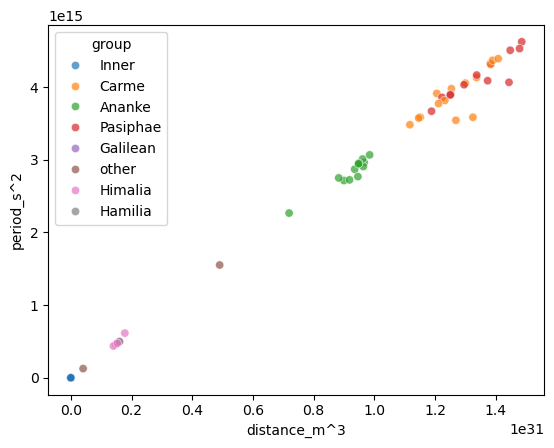

In [24]:
moons["distance_m^3"] = (moons["distance_km"] * 1000) ** 3 ## New column of distance^3 in metres
moons["period_s^2"] = (moons["period_days"] * 86400) ** 2 ## New column of period^2 in seconds

plt.figure()

scat_plot(
    data = moons,
    x = "distance_m^3",
    y = "period_s^2"
)

gradient, _ = np.polyfit(moons["distance_m^3"], moons["period_s^2"], 1)



Now I have a value for the gradient, I can use 
$$\text{gradient} = \frac{4\pi^2}{GM}$$
and rearrange to get 
$$M = \frac{4\pi^2}{G * gradient}$$
where $G = (6.67 \pm 0.005) * 10^{-11}$

In [25]:
G = 6.67E-11
pi = np.pi
Mass = (4 * (pi ** 2))/(G * gradient)
print(f'The mass of Jupiter calculated from the given data values is {Mass:.2e} kg.')

The mass of Jupiter calculated from the given data values is 1.93e+27 kg.


To check if this value of 1.93e+27 kg is accurate to the accepted value of Jupiter's mass, I will find the number of standard deviations it is from the true value of 1.898e+27

In [26]:
def error_propagation(data, G, gradient, M):
    G_err = 0.005E-11
    gradient_err = stats.linregress(data["distance_m^3"], data["period_s^2"]).stderr
    M_err = M * np.sqrt( (G_err / G) ** 2 + (gradient_err / gradient) ** 2 )
    return M_err


mass_uncertainty = error_propagation(moons, G, gradient, Mass)
mass_uncertainty = float(f'{mass_uncertainty:.1g}')
z_score = (Mass - 1.898e+27) / mass_uncertainty

print(f'The mass of Jupiter has an uncertainty of ±{mass_uncertainty:.2e} kg.')
print(f'The calculated mass is {z_score:.2f} standard deviations away from the accepted value of 1.898e+27 kg.')

The mass of Jupiter has an uncertainty of ±2.00e+25 kg.
The calculated mass is 1.75 standard deviations away from the accepted value of 1.898e+27 kg.


As the calculated value is 1.75 standard deviations out from the accepted value, it can be classed statistically as accurate, due to it being within a 2 standard deviation range from the true value, therefore there isn't a significant difference.  
Also, the uncertainty in the value is only 1% of the calculated value, so it is accurate to say that this mass value is very acceptable when compared to the true value.

To validate this model, I will calculate the mass using only the Galilean moons as these are the most accurately observed moons of Jupiter, and compare this value to the previous one.

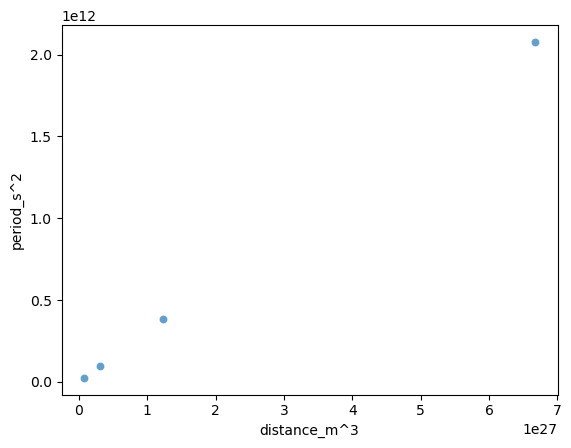

The mass of Jupiter calculated from only the Galilean moons is (1.90e+27 ± 1.00e+24) kg
z_score: 1.44


In [27]:
galilean = moons.loc[moons["group"] == "Galilean", ["moon", "distance_m^3", "period_s^2"]]

plt.figure()
scat_plot(
    data = galilean,
    x = "distance_m^3",
    y = "period_s^2",
    hue = None
)

gradient = np.polyfit(galilean["distance_m^3"], galilean["period_s^2"], 1)[0]

plt.show()

M = (4 * (pi ** 2))/(G * gradient)

mass_uncertainty = error_propagation(galilean, G, gradient, M)
mass_uncertainty = float(f'{mass_uncertainty:.1g}')

z_score = (M - 1.898e+27) / mass_uncertainty
print(f'The mass of Jupiter calculated from only the Galilean moons is ({M:.2e} ± {mass_uncertainty:.2e}) kg')
print(f'z_score: {z_score:.2f}')

This mass is closer to the expected value of mass for Jupiter, which is what I expected to observe, due to these moons being more accurately observed than any of the other moon groups.  
However, this value has a larger z-score than the previous one, as the error in the gradient is much lower dues to a more linear trend on the graph. This means that the uncertainty in the mass is only 0.05% of the total value, therefore the result is incredibly precise, which results in the larger z-score.  

It is more acceptable to use the mass value calculated using the whole collection of moons in the jupiter.db file as the mass from both are just estimates and that mass uses a wide range of different types of moons, making it a more realistic observation overall due to the variety of data.

## <a id='toc1_3_'></a>[Conclusion](#toc0_)

Overall, from this use of Kepler's Third Law, I will take the value of mass of Jupiter to be (1.93 ± 0.02)e+27 kg as it is statistically accurate, as well as using a wide range of data points to keep the value as accurate to the model as possible.

$$M = (1.93 \pm 0.02)e+27 \text{ kg}$$